In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#First we will examine our data to get an idea of what we are working with
ames_train = pd.read_csv('train.csv')
ames_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

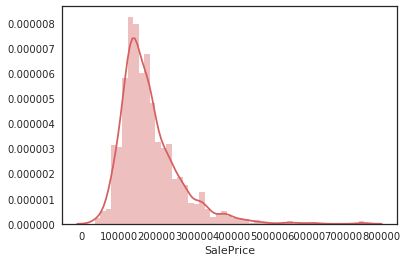

In [3]:
sns.set(style="white", palette="muted", color_codes=True)

#histogram plot for our response variable
sns.distplot(ames_train['SalePrice'], color='r')

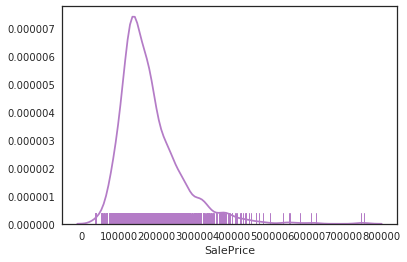

In [4]:
##rug plot for our response variable 
sns.distplot(ames_train['SalePrice'], hist=False, rug=True, color='m');

In [5]:
##print out some basic statistics about our response's distribution
print("Std: %f" % ames_train['SalePrice'].std())
print("Skewness: %f" % ames_train['SalePrice'].skew() )
print( "Kurtosis: %f" % ames_train['SalePrice'].kurt() )

Std: 79442.502883
Skewness: 1.882876
Kurtosis: 6.536282


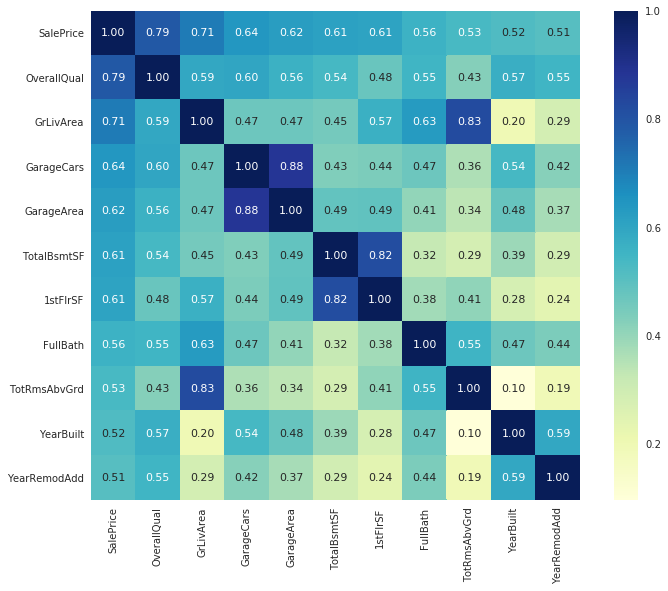

In [6]:
##build a correlation heatmap using the ~10 highest correlated predictors
f, ax = plt.subplots(figsize=(12, 9))
correlation_matrix = ames_train.corr()
cols = correlation_matrix.nlargest(11, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(ames_train[cols].values.T)
sns.set(font_scale=1.0)
hm = sns.heatmap(cm, cbar=True, cmap="YlGnBu", annot=True, square=True, fmt='.2f', annot_kws={'size': 11}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

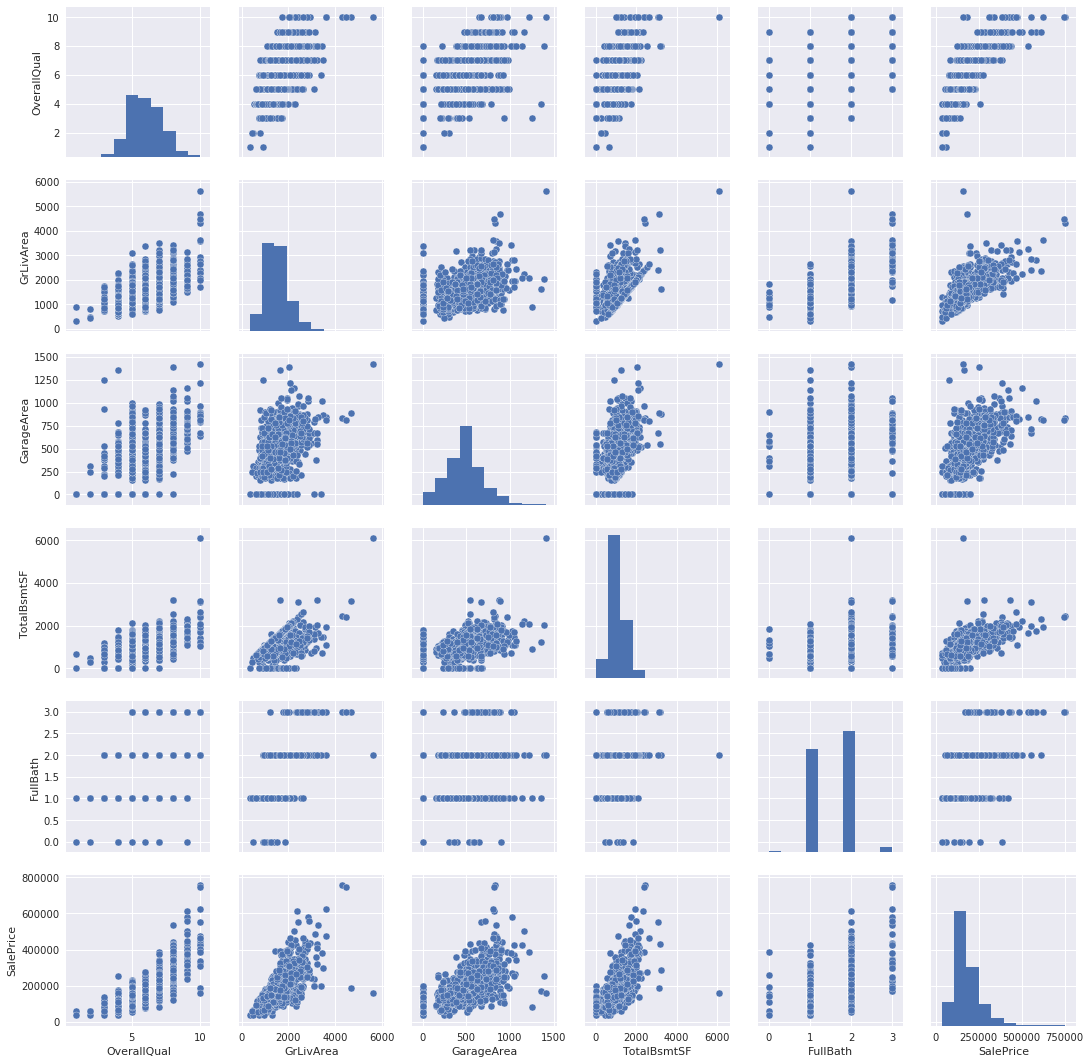

In [7]:
#scatterplot and histogram pair plot
#notice the outliers in the scatter plots
cols=['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'SalePrice']
sns.set()
sns.pairplot(ames_train[cols], size = 2.5)
plt.show()

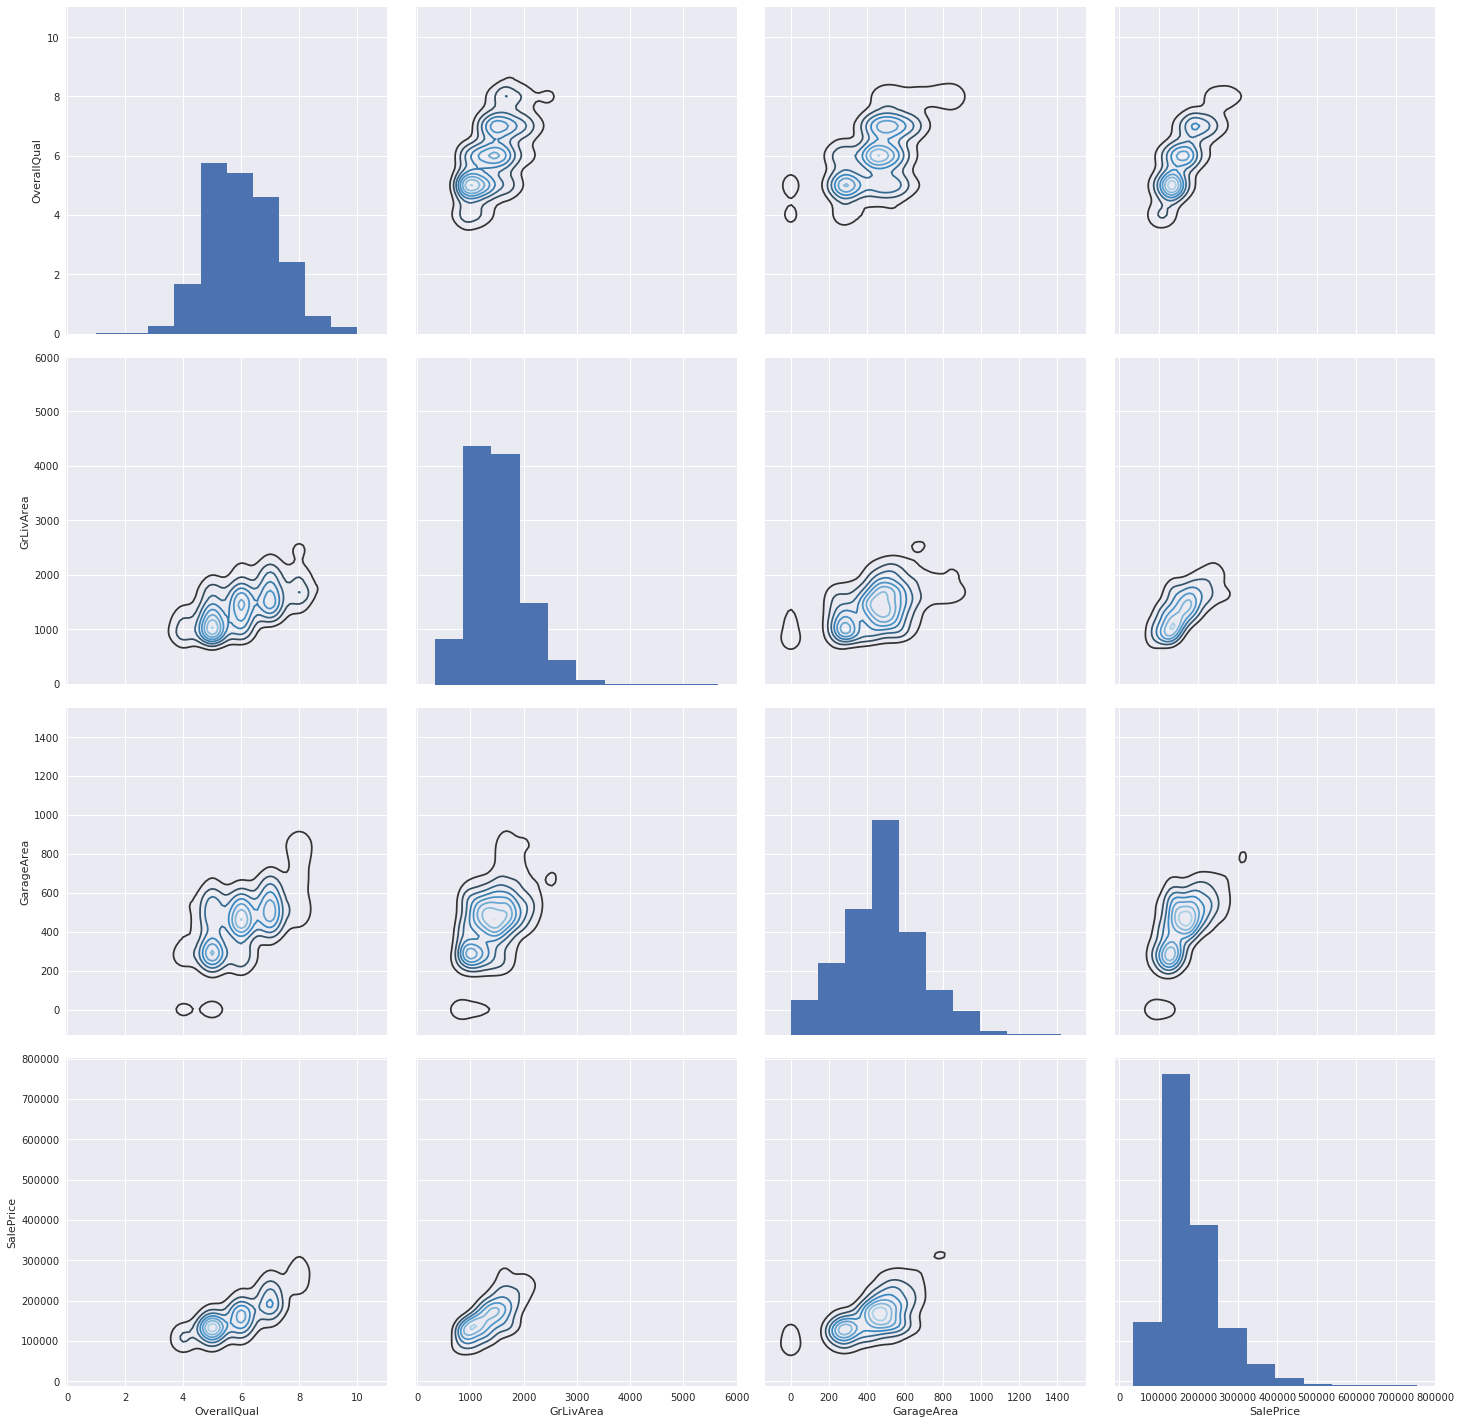

In [8]:
###kernel density plots for the higher correlation variables
##we can see some outliers here as well, along with instances where there are clusters of values around 0
cols=['OverallQual', 'GrLivArea', 'GarageArea','SalePrice']
g = sns.PairGrid( ames_train[cols], size=5 )
g.map_diag(plt.hist)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=8 )
plt.show()

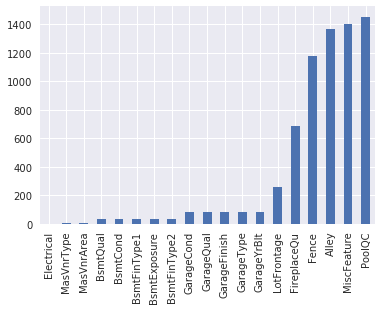

In [9]:
#Now we can begin cleaning and preprocessing the data
#First, find and deal with missing data
missing = ames_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

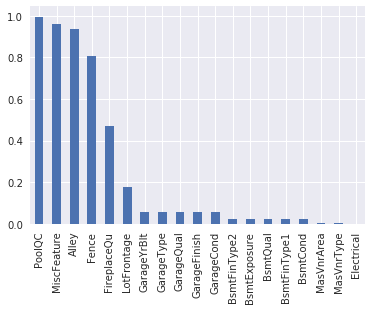

In [10]:
#plot missing values as a percentage
percent = (missing/ames_train.isnull().count()).sort_values(ascending=False)
percent = percent[ percent > 0]
percent.plot.bar()

In [11]:
#I will drop anything with over 10% missing data, none of these variables seem very important anyway
ames_train = ames_train.drop( percent[ percent > 0.10 ].index, axis=1 )

In [12]:
##check data
ames_train.head(5)

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [13]:
##Eliminate 1 missing data member from electrical 
ames_train = ames_train.drop( ames_train.loc[ames_train['Electrical'].isnull()].index )

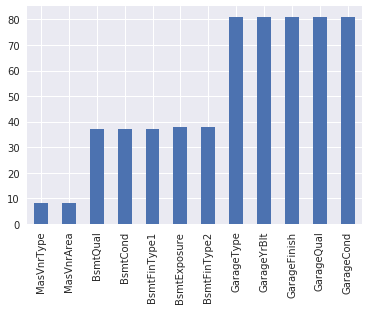

In [14]:
##Now check for missing data 
missing = ames_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [15]:
#I suspect many of the remaining missing values for many of these variables are the same observations
#Printing out missing value locations confirms this
print( ames_train.loc[ames_train['MasVnrType'].isnull()].index )
print( ames_train.loc[ames_train['MasVnrArea'].isnull()].index )

print( ames_train.loc[ames_train['BsmtQual'].isnull()].index )
print( ames_train.loc[ames_train['BsmtCond'].isnull()].index )

print( ames_train.loc[ames_train['BsmtExposure'].isnull()].index )
print( ames_train.loc[ames_train['BsmtFinType2'].isnull()].index )
print( ames_train.loc[ames_train['BsmtFinType1'].isnull()].index )

print( ames_train.loc[ames_train['GarageType'].isnull()].index )
print( ames_train.loc[ames_train['GarageQual'].isnull()].index )

Int64Index([234, 529, 650, 936, 973, 977, 1243, 1278], dtype='int64')
Int64Index([234, 529, 650, 936, 973, 977, 1243, 1278], dtype='int64')
Int64Index([  17,   39,   90,  102,  156,  182,  259,  342,  362,  371,  392,
             520,  532,  533,  553,  646,  705,  736,  749,  778,  868,  894,
             897,  984, 1000, 1011, 1035, 1045, 1048, 1049, 1090, 1179, 1216,
            1218, 1232, 1321, 1412],
           dtype='int64')
Int64Index([  17,   39,   90,  102,  156,  182,  259,  342,  362,  371,  392,
             520,  532,  533,  553,  646,  705,  736,  749,  778,  868,  894,
             897,  984, 1000, 1011, 1035, 1045, 1048, 1049, 1090, 1179, 1216,
            1218, 1232, 1321, 1412],
           dtype='int64')
Int64Index([  17,   39,   90,  102,  156,  182,  259,  342,  362,  371,  392,
             520,  532,  533,  553,  646,  705,  736,  749,  778,  868,  894,
             897,  948,  984, 1000, 1011, 1035, 1045, 1048, 1049, 1090, 1179,
            1216, 1218, 1232, 13

In [16]:
#delete missing observations: there aren't that many compared to our data set size
ames_train = ames_train.drop( ames_train.loc[ames_train['MasVnrType'].isnull()].index )
ames_train = ames_train.drop( ames_train.loc[ames_train['BsmtQual'].isnull()].index )
ames_train = ames_train.drop( ames_train.loc[ames_train['BsmtExposure'].isnull()].index )
ames_train = ames_train.drop( ames_train.loc[ames_train['GarageType'].isnull()].index )
ames_train = ames_train.drop( ames_train.loc[ames_train['BsmtFinType2'].isnull()].index ) ##there is one more here

In [17]:
#Check to make sure we got all of the missing data
ames_train.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
                ..
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch   

In [18]:
# Missing data has been taken care of. Now we can deal with outliers
# Refer to scatter plots from earlier in the notebook, now we can delete some of these outliers
# It looks like the cases where GrLiveArea > 4000, TotalBsmtSF > 4000 and GarageArea > 1250 are outliers, so we 
# Will delete them 
ames_train = ames_train[ ames_train['GrLivArea'] < 4000 ]
ames_train = ames_train[ ames_train['TotalBsmtSF'] < 4000 ]
ames_train = ames_train[ ames_train['GarageArea'] < 1250 ]
# There may be outliers in many of the other variables, but they are likely not so important
# Right now it is best to only be concerned with the most appealing predictors

In [20]:
##It's now time to split our data into numerical and categorical predictors
categorical_features = ames_train.select_dtypes(include = ["object"]).columns
numerical_features = ames_train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")

ames_num = ames_train[numerical_features]
ames_cat = ames_train[categorical_features]

In [21]:
#Check the normality of some of our important predictors
for pred in ['GrLivArea', 'TotalBsmtSF', 'GarageArea', 'FullBath', 'OverallQual', '1stFlrSF', 'GarageCars']:
    print( "Results for " + pred + ":" )
    print(stats.normaltest( ames_train[pred]))
# The p-values reported here are for the null hypothesis that the variable is from a normal distribution
# As we can see, the majority of these variables are likely not from such a distribution
# The 'statistic' value is skewness squared plus kurtosis squared. Many of the non-normal variables have high 
# skewness, kurtosis or both

Results for GrLivArea:
NormaltestResult(statistic=150.66423147598857, pvalue=1.9216656400286613e-33)
Results for TotalBsmtSF:
NormaltestResult(statistic=176.84137528111808, pvalue=3.9754223188900107e-39)
Results for GarageArea:
NormaltestResult(statistic=86.170431100092657, pvalue=1.9423551212839049e-19)
Results for FullBath:
NormaltestResult(statistic=188.73672580982893, pvalue=1.0383427243429248e-41)
Results for OverallQual:
NormaltestResult(statistic=17.98807151950496, pvalue=0.00012414804915421095)
Results for 1stFlrSF:
NormaltestResult(statistic=153.48698389261335, pvalue=4.6851653824842886e-34)
Results for GarageCars:
NormaltestResult(statistic=11.695436294966658, pvalue=0.0028864781665387182)


In [24]:
#I will apply log-transform to all features where we reject null hypothesis, alpha = 0.01
def get_p( x ):
    s, p = stats.normaltest(x)
    return p
alpha = 0.01
norm_p = ames_num.apply(lambda x : get_p(x))
norm_p = norm_p[norm_p < alpha]
print(str(norm_p.shape[0]) + " numerical features to log transform")
logt_features = norm_p.index
ames_num[logt_features] = np.log1p(ames_num[logt_features])

36 numerical features to log transform


In [25]:
#also we will log-transform the response variable
ames_train['SalePrice'] = np.log( ames_train['SalePrice'])

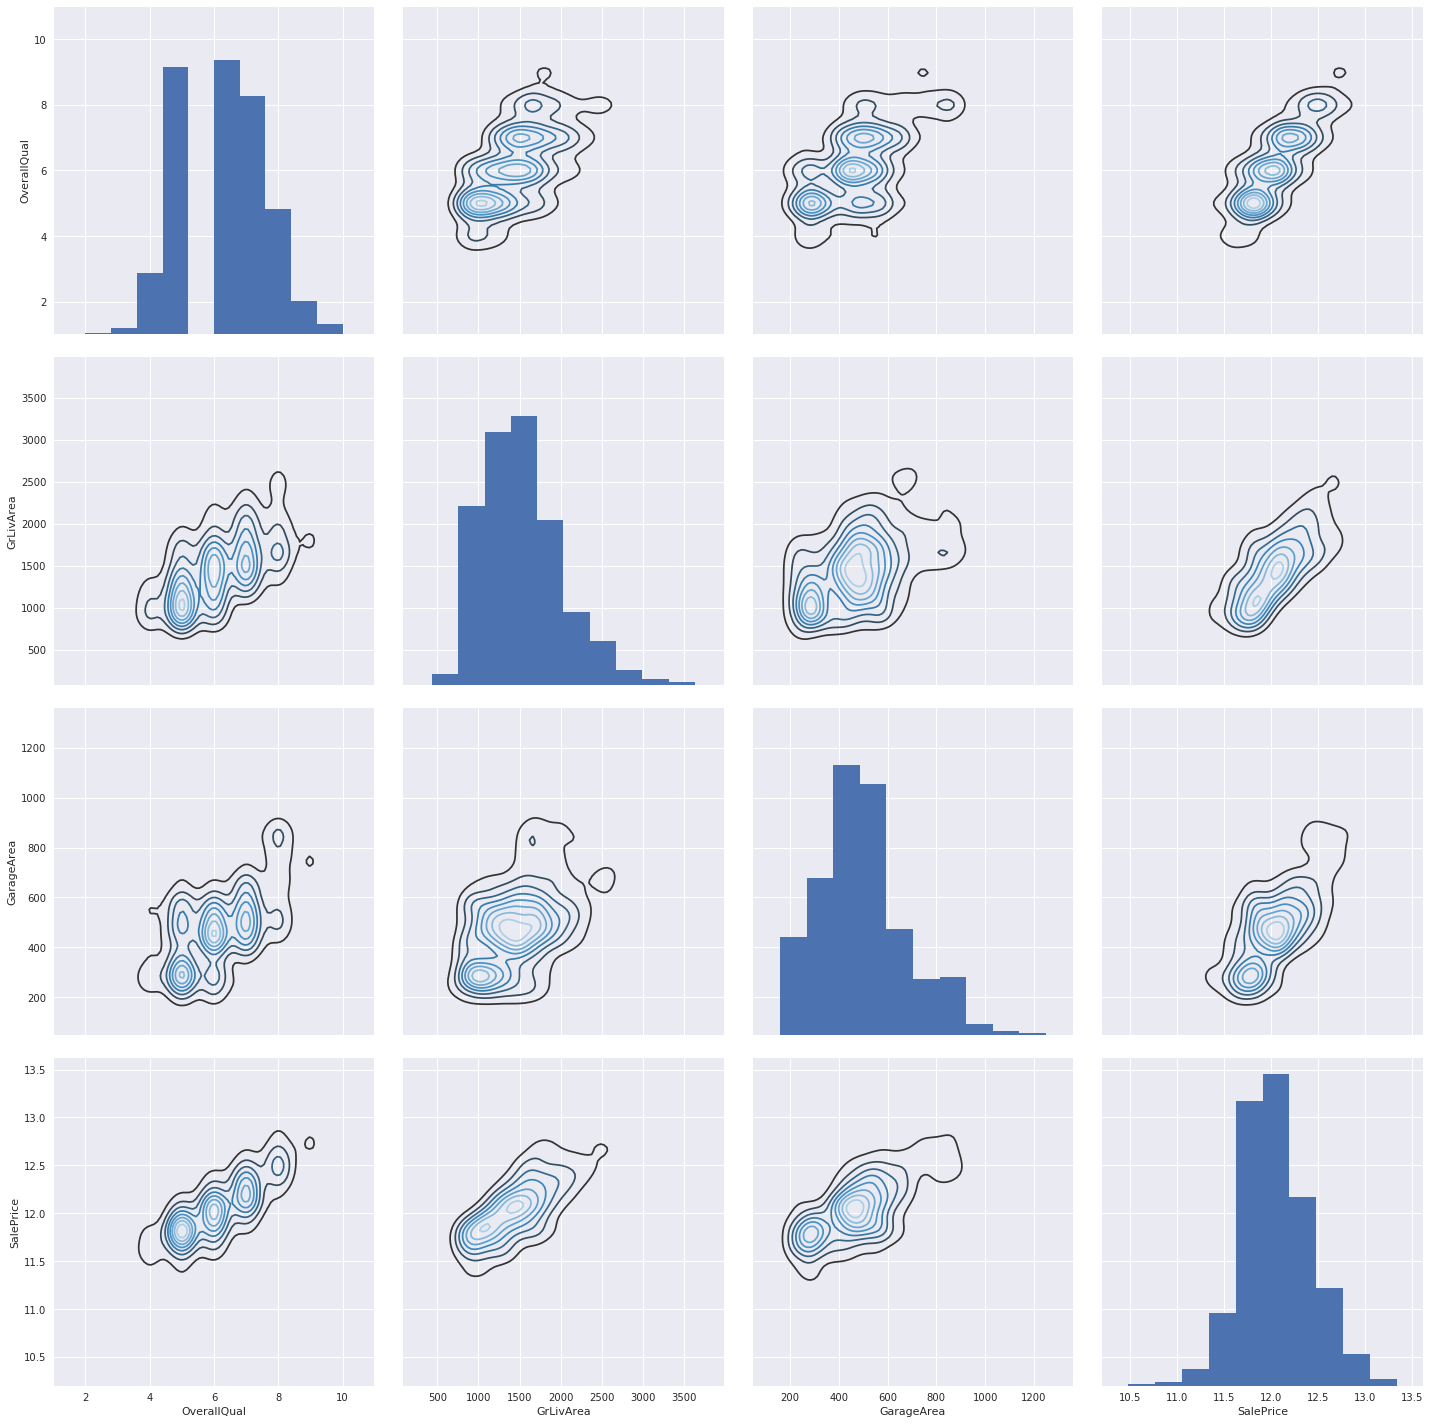

In [26]:
# Look at some kernel denisty plots again
# The histograms and KDE plots look better
# Kernel density plots for the higher correlation variables
# We can see some outliers here as well, along with instances where there are clusters of values around 0
cols=['OverallQual', 'GrLivArea', 'GarageArea','SalePrice']
g = sns.PairGrid( ames_train[cols], size=5 )
g.map_diag(plt.hist)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=8 )
plt.show()

In [27]:
# Add dummy variables for categorical variables
ames_cat = pd.get_dummies(ames_cat)
# Check to make sure there are no missing vals ( again )
print("NAs for categorical features in train : " + str(ames_cat.isnull().values.sum()))

NAs for categorical features in train : 0
